# Feature Engineering Notebook

## Objectives

* Enhance features for dog breed classification using pre-trained VGG16 features.
* Implement data augmentation to improve model generalization.
* Explore dimensionality reduction techniques to simplify models and improve interpretation.


## Inputs

* outputs/x_test.csv Testing set features extracted via VGG16.
* outputs/x_train.csv Training set features extracted via VGG16.
* outputs/y_train.csv Training set labels.
* outputs/y_train.csv Testing set labels.

## Outputs

* Generate a list with engineered variables and transformation summaries.

## Conclusions



* Summarize the effectiveness of feature engineering transformations applied, focusing on tailored features, augmentation and dimensionality reduction.
  


---

# Change working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [1]:
import os
current_dir = os.getcwd()
current_dir

'/home/jaaz/Desktop/project-5/TailTeller/jupyter_notebooks'

We want to make the parent of the current directory the new current directory.
* os.path.dirname() gets the parent directory
* os.chdir() defines the new current directory

In [2]:
os.chdir(os.path.dirname(current_dir))
print("New current directory:", os.getcwd())

New current directory: /home/jaaz/Desktop/project-5/TailTeller


Confirm the new current directory

In [3]:
current_dir = os.getcwd()
current_dir

'/home/jaaz/Desktop/project-5/TailTeller'

---

# Load Cleaned Data

Train Set

In [4]:
import pandas as pd
train_set_path = "outputs/x_train.csv"
train_features = pd.read_csv(train_set_path)
train_labels_path = "outputs/y_train.csv"
train_labels = pd.read_csv(train_labels_path)

Test Set

In [5]:
test_set_path = "outputs/x_test.csv"
test_features = pd.read_csv(test_set_path)
test_labels_path = "outputs/y_test.csv"
test_labels = pd.read_csv(test_labels_path)

Ensuring all images are the same size to work with CNN architecture.
Normalizing the scale pixel values to a range.

In [6]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

2024-05-05 19:13:12.058551: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-05 19:13:12.133041: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Data Augmentation

Apply PCA to explore data structure and reduce feature dimensionality.

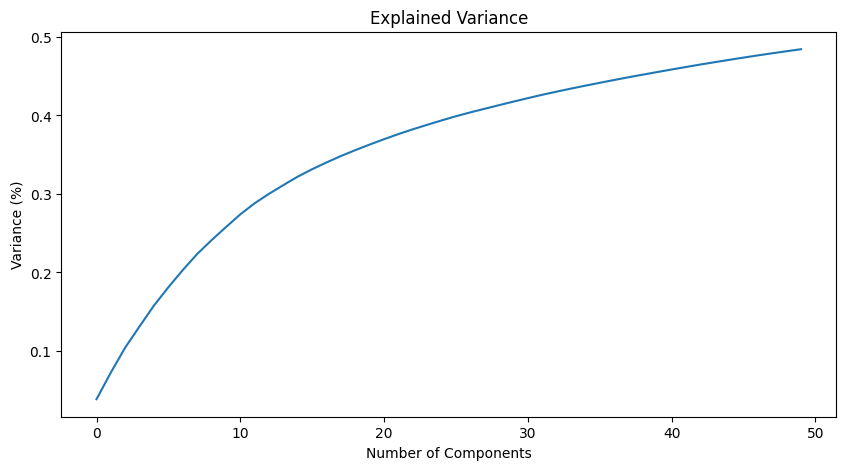

In [11]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# Reduce to 50 components
pca = PCA(n_components=50)
pca_features = pca.fit_transform(train_features)

plt.figure(figsize=(10, 5))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)')
plt.title('Explained Variance')
plt.show()

# Feature Engineering

* Implement custom feature transformations tailored to enhancing distinctions between dog breeds.

In [23]:
train_features['aspect_ratio'] = train_features['height'] / train_features['width']

## Custom function

We studied this custom function in the feature-engine lesson. That will help you with the feature engineering process.
* Do not worry if you need help understanding the full code at first, as it is expected you will take some time to absorb the use case.
* At this moment, what matters is to understand the function objective and how you can use it.

In [ ]:
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import warnings
from feature_engine import transformation as vt
from feature_engine.outliers import Winsorizer
from feature_engine.encoding import OrdinalEncoder
sns.set(style="whitegrid")
warnings.filterwarnings('ignore')


def FeatureEngineeringAnalysis(df, analysis_type=None):
    """
    - used for quick feature engineering on numerical and categorical variables
    to decide which transformation can better transform the distribution shape
    - Once transformed, use a reporting tool, like ydata-profiling, to evaluate distributions
    """
    check_missing_values(df)
    allowed_types = ['numerical', 'ordinal_encoder', 'outlier_winsorizer']
    check_user_entry_on_analysis_type(analysis_type, allowed_types)
    list_column_transformers = define_list_column_transformers(analysis_type)

    # Loop in each variable and engineer the data according to the analysis type
    df_feat_eng = pd.DataFrame([])
    for column in df.columns:
        # create additional columns (column_method) to apply the methods
        df_feat_eng = pd.concat([df_feat_eng, df[column]], axis=1)
        for method in list_column_transformers:
            df_feat_eng[f"{column}_{method}"] = df[column]

        # Apply transformers in respective column_transformers
        df_feat_eng, list_applied_transformers = apply_transformers(
            analysis_type, df_feat_eng, column)

        # For each variable, assess how the transformations perform
        transformer_evaluation(
            column, list_applied_transformers, analysis_type, df_feat_eng)

    return df_feat_eng


def check_user_entry_on_analysis_type(analysis_type, allowed_types):
    """ Check analysis type """
    if analysis_type is None:
        raise SystemExit(
            f"You should pass analysis_type parameter as one of the following options: {allowed_types}")
    if analysis_type not in allowed_types:
        raise SystemExit(
            f"analysis_type argument should be one of these options: {allowed_types}")


def check_missing_values(df):
    if df.isna().sum().sum() != 0:
        raise SystemExit(
            f"There is a missing value in your dataset. Please handle that before getting into feature engineering.")


def define_list_column_transformers(analysis_type):
    """ Set suffix columns according to analysis_type"""
    if analysis_type == 'numerical':
        list_column_transformers = [
            "log_e", "log_10", "reciprocal", "power", "box_cox", "yeo_johnson"]

    elif analysis_type == 'ordinal_encoder':
        list_column_transformers = ["ordinal_encoder"]

    elif analysis_type == 'outlier_winsorizer':
        list_column_transformers = ['iqr']

    return list_column_transformers


def apply_transformers(analysis_type, df_feat_eng, column):
    for col in df_feat_eng.select_dtypes(include='category').columns:
        df_feat_eng[col] = df_feat_eng[col].astype('object')

    if analysis_type == 'numerical':
        df_feat_eng, list_applied_transformers = FeatEngineering_Numerical(
            df_feat_eng, column)

    elif analysis_type == 'outlier_winsorizer':
        df_feat_eng, list_applied_transformers = FeatEngineering_OutlierWinsorizer(
            df_feat_eng, column)

    elif analysis_type == 'ordinal_encoder':
        df_feat_eng, list_applied_transformers = FeatEngineering_CategoricalEncoder(
            df_feat_eng, column)

    return df_feat_eng, list_applied_transformers


def transformer_evaluation(column, list_applied_transformers, analysis_type, df_feat_eng):
    # For each variable, assess how the transformations perform
    print(f"* Variable Analyzed: {column}")
    print(f"* Applied transformation: {list_applied_transformers} \n")
    for col in [column] + list_applied_transformers:

        if analysis_type != 'ordinal_encoder':
            DiagnosticPlots_Numerical(df_feat_eng, col)

        else:
            if col == column:
                DiagnosticPlots_Categories(df_feat_eng, col)
            else:
                DiagnosticPlots_Numerical(df_feat_eng, col)

        print("\n")


def DiagnosticPlots_Categories(df_feat_eng, col):
    plt.figure(figsize=(4, 3))
    sns.countplot(data=df_feat_eng, x=col, palette=[
                  '#432371'], order=df_feat_eng[col].value_counts().index)
    plt.xticks(rotation=90)
    plt.suptitle(f"{col}", fontsize=30, y=1.05)
    plt.show()
    print("\n")


def DiagnosticPlots_Numerical(df, variable):
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    sns.histplot(data=df, x=variable, kde=True, element="step", ax=axes[0])
    stats.probplot(df[variable], dist="norm", plot=axes[1])
    sns.boxplot(x=df[variable], ax=axes[2])

    axes[0].set_title('Histogram')
    axes[1].set_title('QQ Plot')
    axes[2].set_title('Boxplot')
    fig.suptitle(f"{variable}", fontsize=30, y=1.05)
    plt.tight_layout()
    plt.show()


def FeatEngineering_CategoricalEncoder(df_feat_eng, column):
    list_methods_worked = []
    try:
        encoder = OrdinalEncoder(encoding_method='arbitrary', variables=[
                                 f"{column}_ordinal_encoder"])
        df_feat_eng = encoder.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_ordinal_encoder")

    except Exception:
        df_feat_eng.drop([f"{column}_ordinal_encoder"], axis=1, inplace=True)

    return df_feat_eng, list_methods_worked


def FeatEngineering_OutlierWinsorizer(df_feat_eng, column):
    list_methods_worked = []

    # Winsorizer iqr
    try:
        disc = Winsorizer(
            capping_method='iqr', tail='both', fold=1.5, variables=[f"{column}_iqr"])
        df_feat_eng = disc.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_iqr")
    except Exception:
        df_feat_eng.drop([f"{column}_iqr"], axis=1, inplace=True)

    return df_feat_eng, list_methods_worked


def FeatEngineering_Numerical(df_feat_eng, column):
    list_methods_worked = []

    # LogTransformer base e
    try:
        lt = vt.LogTransformer(variables=[f"{column}_log_e"])
        df_feat_eng = lt.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_log_e")
    except Exception:
        df_feat_eng.drop([f"{column}_log_e"], axis=1, inplace=True)

    # LogTransformer base 10
    try:
        lt = vt.LogTransformer(variables=[f"{column}_log_10"], base='10')
        df_feat_eng = lt.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_log_10")
    except Exception:
        df_feat_eng.drop([f"{column}_log_10"], axis=1, inplace=True)

    # ReciprocalTransformer
    try:
        rt = vt.ReciprocalTransformer(variables=[f"{column}_reciprocal"])
        df_feat_eng = rt.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_reciprocal")
    except Exception:
        df_feat_eng.drop([f"{column}_reciprocal"], axis=1, inplace=True)

    # PowerTransformer
    try:
        pt = vt.PowerTransformer(variables=[f"{column}_power"])
        df_feat_eng = pt.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_power")
    except Exception:
        df_feat_eng.drop([f"{column}_power"], axis=1, inplace=True)

    # BoxCoxTransformer
    try:
        bct = vt.BoxCoxTransformer(variables=[f"{column}_box_cox"])
        df_feat_eng = bct.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_box_cox")
    except Exception:
        df_feat_eng.drop([f"{column}_box_cox"], axis=1, inplace=True)

    # YeoJohnsonTransformer
    try:
        yjt = vt.YeoJohnsonTransformer(variables=[f"{column}_yeo_johnson"])
        df_feat_eng = yjt.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_yeo_johnson")
    except Exception:
        df_feat_eng.drop([f"{column}_yeo_johnson"], axis=1, inplace=True)

    return df_feat_eng, list_methods_worked


## Feature Engineering Spreadsheet Summary

* Consider the notes taken in your spreadsheet summary. List the transformers you will use
    * Categorical Encoding
    * Numerical Transformation
    * Smart Correlation Selection

## Dealing with Feature Engineering

### Categorical Encoding - Ordinal: replaces categories with ordinal numbers 

* Step 1: Select variable(s)

In [ ]:
variables_engineering= ['gender', 'Partner', 'Dependents',
                        'PhoneService', 'MultipleLines', 'InternetService',
                        'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 
                        'TechSupport', 'StreamingTV', 'StreamingMovies',
                        'Contract', 'PaperlessBilling', 'PaymentMethod']

variables_engineering

* Step 2: Create a separate DataFrame, with your variable(s)

In [ ]:
df_engineering = TrainSet[variables_engineering].copy()
df_engineering.head(3)

* Step 3: Create engineered variables(s) by applying the transformation(s), assess engineered variables distribution and select the most suitable method for each variable.

In [ ]:
df_engineering = FeatureEngineeringAnalysis(df=df_engineering, analysis_type='ordinal_encoder')

* For each variable, write your conclusion on how the transformation(s) look(s) to be effective.
  * For all variables, the transformation is effective, since it converted categories to numbers.



* Step 4 - Apply the selected transformation to the Train and Test set

In [ ]:
# the steps are: 
# 1 - create a transformer
# 2 - fit_transform into TrainSet
# 3 - transform into TestSet 
encoder = OrdinalEncoder(encoding_method='arbitrary', variables = variables_engineering)
TrainSet = encoder.fit_transform(TrainSet)
TestSet = encoder.transform(TestSet)

print("* Categorical encoding - ordinal transformation done!")

### Numerical Transformation

* Step 1: Select variable(s)

In [ ]:
variables_engineering = ['tenure', 'MonthlyCharges']
variables_engineering

* Step 2: Create a separate DataFrame, with your variable(s)

In [ ]:
df_engineering = TrainSet[variables_engineering].copy()
df_engineering.head(3)

* Step 3: Create engineered variables(s) by applying the transformation(s), assess engineered variables distribution and select the most suitable method

In [ ]:
df_engineering = FeatureEngineeringAnalysis(df=df_engineering, analysis_type='numerical')

* For each variable, write your conclusion on how the transformation(s) look(s) to be effective
  * For all variables - it didn't improve the boxplot distribution or qq plot


* Step 4 - Apply the selected transformation to the Train and Test set

In [ ]:
# we are not applying any numerical transformation to the data

### SmartCorrelatedSelection Variables

* Step 1: Select variable(s)

In [ ]:
# for this transformer, you don't need to select variables, since you need all variables for this transformer

* Step 2: Create a separate DataFrame, with your variable(s)

In [ ]:
df_engineering = TrainSet.copy()
df_engineering.head(3)

* Step 3: Create engineered variables(s) applying the transformation(s)

In [ ]:
from feature_engine.selection import SmartCorrelatedSelection
corr_sel = SmartCorrelatedSelection(variables=None, method="spearman", threshold=0.6, selection_method="variance")

corr_sel.fit_transform(df_engineering)
corr_sel.correlated_feature_sets_

In [ ]:
corr_sel.features_to_drop_

---

# So what is the conclusion? :)


The list below shows the transformations needed for feature engineering.
  * You will add these steps to the ML Pipeline


Feature Engineering Transformers
  * Ordinal categorical encoding: `['gender', 'Partner', Dependents', 'PhoneService','MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']`
  * Smart Correlation Selection: `['OnlineSecurity', 'DeviceProtection', 'TechSupport']`
  

* Well done! Clear the outputs, and move on to the following notebook.